In [4]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from tf_keras_vis.activation_maximization import ActivationMaximization


import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [5]:
# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [6]:
## these can also be globally set.
trial_seed = 1
class_labels = getClassLabels("PrPo_Im")
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)

In [7]:
GLOBAL_MODEL = models.load_model(FULL_MODEL_PATH)

Obtaining the class activation maps (CAM) and gradients from the three visualization techniques.

In [8]:
def grad_cam(index): 
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    probPrediction = [] # store probability of prediction by the CNN
    predictedClass = [] # store CNN-predicted class 
    print("Observed image class: ", class_labels[np.argmax(validation_labels[cam_img])])
    m = GLOBAL_MODEL
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_img] ])]
        print(loss_list)
        probPrediction.append(str([np.round(max(softmax(loss)), 2) for loss in output.numpy()])[1:-1])
        predictedClass.append(class_labels[np.argmax([softmax(loss) for loss in output.numpy()])])
        print('Probability of prediction: ', probPrediction)
        print('Predicted class: ', predictedClass)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    print('Class labels: ', class_labels)
    
    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear # Assign linear activation function (pass-through) to the activation of layer at -1
        return model
    
    gradcam_image = validation_images[cam_img]
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) # Penultimate layer is a fully-connected hidden layer. 
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image, probPrediction, predictedClass

In [9]:
def guided_backprop(index, activation_layer):
    # Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=jgTRCYgX4oz-&line=1&uniqifier=1  
    backprop_image = validation_images[index]    
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
        return tf.nn.relu(x), grad

    model = models.load_model(FULL_MODEL_PATH) # set model inside the function
    modified_model = models.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(activation_layer).output]
    )
    layer_dict = [layer for layer in modified_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as tape:
        inputs = tf.cast(backprop_image, tf.float32)
        tape.watch(inputs)
        outputs = modified_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]
    return grads  

In [10]:
def guided_gradcam(index, normalize=False):
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    gbp = guided_backprop([index], 'conv2d_4')
    if normalize:
        gbp = deprocess_image(np.array(np.squeeze(gbp)))
    else:
        gbp = np.squeeze(gbp)
        
    ggcam = grad_cam([index])[0] * gbp
    
    print('Shape of GGCAM: ', ggcam.shape)
    return ggcam

Visually rendering the outputs of the three functions and the original image from the validation set.

In [11]:
def renderOriginal(index, save=False, c_map='gist_gray'):
    '''Plot the original image found in the validation set.'''
    originals_dir = '../../figures/plottingOriginals/'
    print('Observation: ',class_labels[np.argmax(validation_labels[index])])
    standardizePlot(index, originals_dir, 'Original Image (validation) in '+ c_map)
    plt.imshow(np.squeeze(validation_images[index]), cmap=c_map)
    if save:
        plt.savefig(originals_dir+'original-'+str(index)+'-'+c_map+'.jpg')

In [12]:
def renderGradCam(index, save=False, c_map='gist_gray'):
    '''Visualizing gradient-weighted class activation maps as an overlay (heatmap) to the original image.'''
    gradcam_dir = '../../figures/plottingGradCam/'
    gcam = grad_cam([index])
    class_labels = getClassLabels("PrPo_Im")
    
    plt.figure(figsize=(5, 5))
    plt.suptitle('Grad-CAM Index '+str(index)[1:-1]+'\n')
    plt.title('Observed class: '+class_labels[np.argmax(validation_labels[index])], y=-0.08)
    plt.text(-0.7,-0.05, "Probability of prediction: "+ str("{:.0%}".format(float(str(gcam[2])[2:-2])))+'\n', size=12)
    plt.text(-0.7,-0.35, 'Predicted class: '+ str(gcam[3])[2:-2], size=12)
    plt.axis('off')
    plt.tight_layout()
    heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
    plt.imshow(np.squeeze(gcam[1]), cmap=c_map) # remove axes of length one from gradcam_images
    plt.imshow(heatmap, cmap='gist_gray', alpha=0.5) # overlay
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    if save:
        if not os.path.exists(gradcam_dir):
            os.makedirs(gradcam_dir)
        plt.savefig(gradcam_dir+"gradcam-"+str(index)[1:-1]+".png")
        
    plt.show()

In [13]:
def renderGBP(index, normalize=False, save=False, c_map='gist_gray'):
    '''Visualizing Guided Backpropagation with an option to use normalized gradients.'''
    gbp = guided_backprop([index], 'conv2d_4')
    gbp_dir = '../../figures/plottingBackProp/'
    save_name = ''
    
    print(np.squeeze(gbp).shape)
    
    standardizePlot(index, gbp_dir, 'Guided Backpropagation')    
    
    if normalize:
        save_name = gbp_dir+"guided_backprop-"+str(index)+'-normalized-'+c_map+".png"
        normalize_gbp = deprocess_image(np.array(np.squeeze(gbp)))
        plt.imshow(normalize_gbp, cmap = c_map)
    else:
        save_name = gbp_dir+"guided_backprop-"+str(index)+'-'+c_map+".png"
        plt.imshow(np.squeeze(gbp), cmap=c_map)
    
    if save:
        plt.savefig(save_name)

In [14]:
def renderGGCAM(index, normalize=False, save=False, c_map='gist_gray'):
    '''Visualizing Guided Grad-CAM output with an option to use normalized guided backpropagation gradients.'''
    ggcam_dir = '../../figures/plottingGuided-GradCam/'
    plot_name = ''
        
    if normalize:
        plot_name = "guided-gradcam-"+str(index)+'-'+c_map+'-normalized.png'
        ggcam = guided_gradcam(index, True)
        print('Using normalized GBP gradients...')
    else:
        plot_name = "guided-gradcam-"+str(index)+'-'+c_map+".png"
        ggcam = guided_gradcam(index)
    
    standardizePlot(index, ggcam_dir, 'Guided Grad-CAM')
    plt.imshow(ggcam, cmap=c_map)    
    
    if save:
        plt.savefig(ggcam_dir+plot_name)
        print('Saving '+plot_name+' in '+ggcam_dir)
        
    plt.show()

Observation:  Improbable


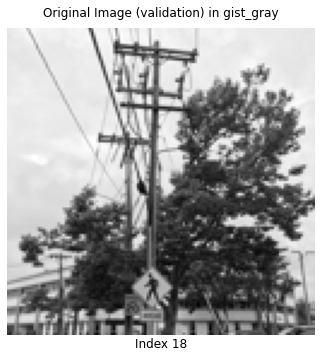

In [15]:
renderOriginal(18)

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-9.487238 12.32506 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=12.32506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([3.3654213e-10, 1.0000000e+00], dtype=float32)]
Shape of heatmap matrix: (128, 128)


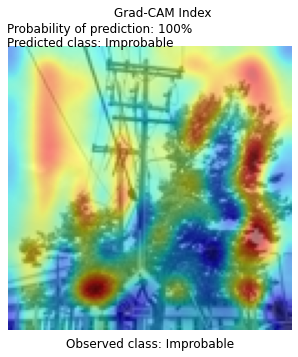

In [16]:
renderGradCam(18)

(128, 128)


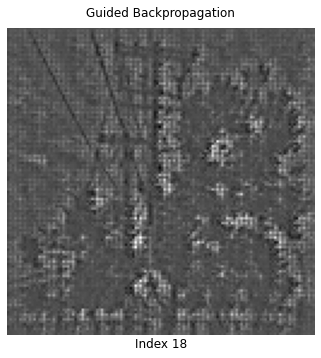

In [17]:
renderGBP(18)

(128, 128)


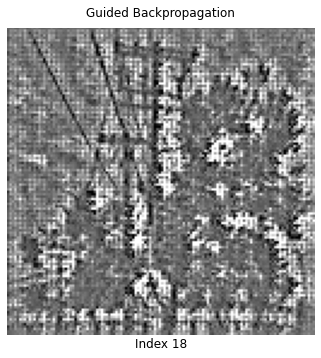

In [18]:
renderGBP(18, True)

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-9.487238 12.32506 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=12.32506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([3.3654213e-10, 1.0000000e+00], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)


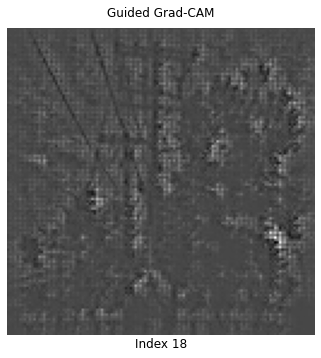

In [19]:
renderGGCAM(18)

Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-9.487238 12.32506 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=12.32506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([3.3654213e-10, 1.0000000e+00], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)
Using normalized GBP gradients...


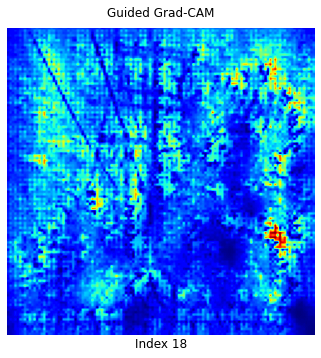

In [14]:
renderGGCAM(18, True, False, 'jet')

In [35]:
def plotVisualizations(index):
    subplot_args = { 'nrows': 2, 'ncols': 2, 'figsize': (5,5), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    ax[0, 0] = renderOriginal(index)
    ax[0, 1] = renderGradCam(index)
    ax[1, 0] = renderGBP(index)
    ax[1, 1] = renderGGCAM(index)
        #print(heatmap.shape)
#         ax[i, j].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
#         image_counter += 1

Observation:  Improbable
Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-9.487238 12.32506 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=12.32506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([3.3654213e-10, 1.0000000e+00], dtype=float32)]
Shape of heatmap matrix: (128, 128)


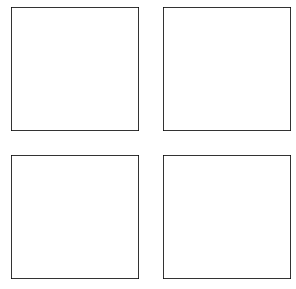

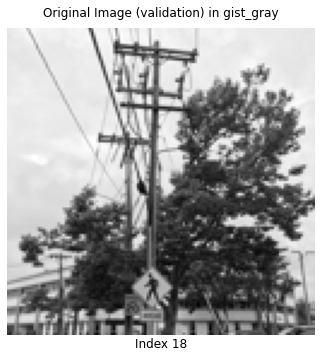

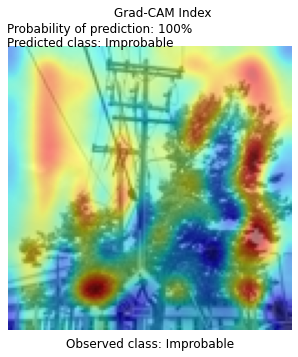

(128, 128)
Observed image class:  Improbable
Class labels:  ['Probable/Possible', 'Improbable']
Loss output:  tf.Tensor([[-9.487238 12.32506 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=12.32506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Improbable']
[array([3.3654213e-10, 1.0000000e+00], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Shape of GGCAM:  (128, 128)


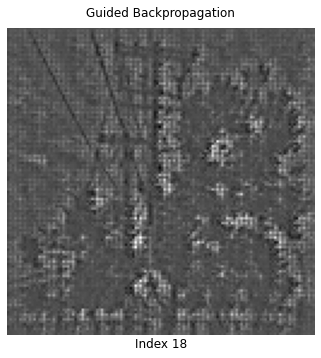

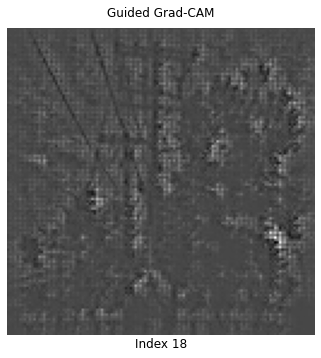

In [36]:
plotVisualizations(18)